<a href="https://colab.research.google.com/github/Michael-HK/Fake-Job-detection/blob/main/fake_job_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import dependencies**

In [ ]:
#=======Install transformer=====================

!pip install -q transformers
!pip install sadice
!pip install contractions
!pip install inflect
!pip install --upgrade accelerate
!pip uninstall -y transformers accelerate
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 69.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This

In [ ]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

##nlp preprocessing libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import contractions
import inflect

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#from google.colab import files
#files.upload()

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# change directory to the job folder
%cd /content/drive/My Drive/end_2_end_ML/fake_job_detection


#================unzip file===============

#from zipfile import ZipFile
#file_name="./fake_job_postings.csv.zip"

#with ZipFile(file_name,'r') as zip:
##  zip.extractall()
#  print('Done')

#======load the data====================

pd.options.display.max_rows = 10
df = pd.read_csv('fake_job_postings.csv')
df.info()

/content/drive/My Drive/end_2_end_ML/fake_job_detection
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 1

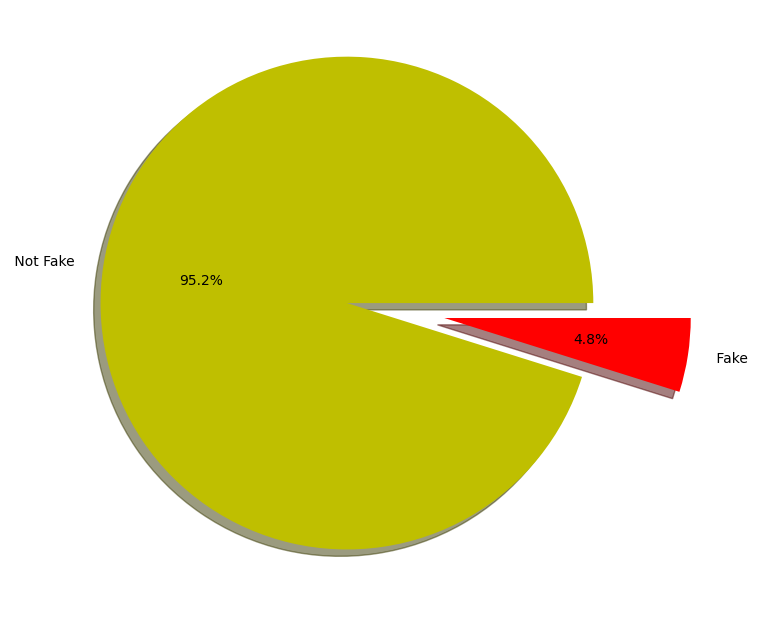

In [ ]:
#plt.figure(figsize=(10,5))
#sns.countplot(df['fraudulent']);

y = [df[df['fraudulent']==0].shape[0] , df[df['fraudulent']==1].shape[0]]
mylabels = [" Not Fake " , " Fake "]
myexplode = [0.4, 0]
plt.figure(figsize=(12, 8))
plt.pie(y, labels = mylabels, explode = myexplode , autopct='%1.1f%%' , shadow = True , colors = ['y' , 'r'])
plt.show()

#plt.figure(figsize=(10,5))
#sns.countplot(y);

**Data preprocessing**

In [ ]:

def data_details(df) :
    df.replace('?' , np.nan , inplace = True )
    nulls = (df.shape[0] - df.dropna(axis = 0).shape[0])
    nulls_per = (df.shape[0] - df.dropna(axis = 0).shape[0]) / df.shape[0]
    dup , dup_per = df.duplicated().sum() , (df.duplicated().sum()) / df.shape[0]
    numerical_columns = list((df.select_dtypes(include=np.number)).columns)
    categorical_columns = list(df.select_dtypes(include = ['object']).columns)
    numeric_col = {}
    for col in numerical_columns :
        if df[col].nunique() > 10 :
            numeric_col[col] = 'Continuous'

        else :
            numeric_col[col] = 'Discrete'
    categorical_col = {}
    for col in categorical_columns :
        if df[col].nunique() > 10 :
            categorical_col[col] = 'Continuous'

        else :
            categorical_col[col] = 'Classes'
    x = []
    for col in df.columns :
        x.append([col , df[col].unique() ,df[col].nunique(),df[col].dtype,df[col].isna().sum(),int((df[col].isna().sum())/df.shape[0] * 100)  ])

    x = pd.DataFrame(x ,columns=['Feature','Unique_Values','No.OfUniqueValues','DataType','NoOfNulls','Nulls %'])

    print('\n','There is : {}  Nulls, Representing {} % of The Data'.format(nulls , '%.2f'%nulls_per ))
    print('\n','There is : {}  Duplicated, Representing {} % of The Data'.format(dup , '%.2f'%dup_per))
    print('\n','Numerical Columns : {}'.format(numeric_col))
    print('\n','Categorical Columns : {}'.format(categorical_col))

    return x

In [ ]:
#======= clean the data=========================================================

#=====================Load the data into a Pandas DataFrame=====================

df.drop('job_id' , axis = 1 ,inplace = True)
df.reset_index(drop=True ,inplace=True)

#==== replace 'nan' department with the key opening word in the job title=======

for idx in (df[df['department'].isna()]['title'].index) :
    if 'Marketing' in df.at[idx ,'title' ] :
        df.at[idx , 'department'] = 'Marketing'
    elif 'Sales' in df.at[idx ,'title' ] :
        df.at[idx , 'department'] = 'Sales'
    elif ('Accountant' in df.at[idx ,'title' ])|('Accounting' in df.at[idx ,'title' ] ) :
        df.at[idx , 'department'] = 'Accounting'
    elif ('Engineer' in df.at[idx ,'title' ] )|('Engineering' in df.at[idx ,'title' ] ) :
        df.at[idx , 'department'] = 'Engineering'
    else :
        df.at[idx , 'department'] = df.at[idx , 'title']

##========fill some nan columns appropriately===================================

df[['company_profile' , 'description','requirements','benefits']] = df[['company_profile' , 'description','requirements','benefits']].fillna('no available data')
df['location'] = df['location'].fillna('not specify')

df[['industry' , 'function']] = df[['industry' , 'function']].fillna('')

df[['employment_type','required_experience','required_education']] = df[['employment_type','required_experience','required_education']].fillna('Other')

for idx in (df['salary_range'].dropna()).index :
    Range = df.at[idx , 'salary_range'].split('-')
    try :
        start = int(Range[0])
        if start < 1000 :
            df.at[idx ,'salary_range' ] = 0
        else :
            df.at[idx ,'salary_range' ] = start

    except ValueError :
        df.at[idx ,'salary_range' ] = 0

df['salary_range'] = df['salary_range'].fillna(0)


##=== function to convert fraudulent column===
def categ(a):
  if a==0:
    return 'Not Fake'
  else:
    return 'Fake'

df['fraudulent_cat'] = df['fraudulent'].apply(categ)


**EDA analysis**

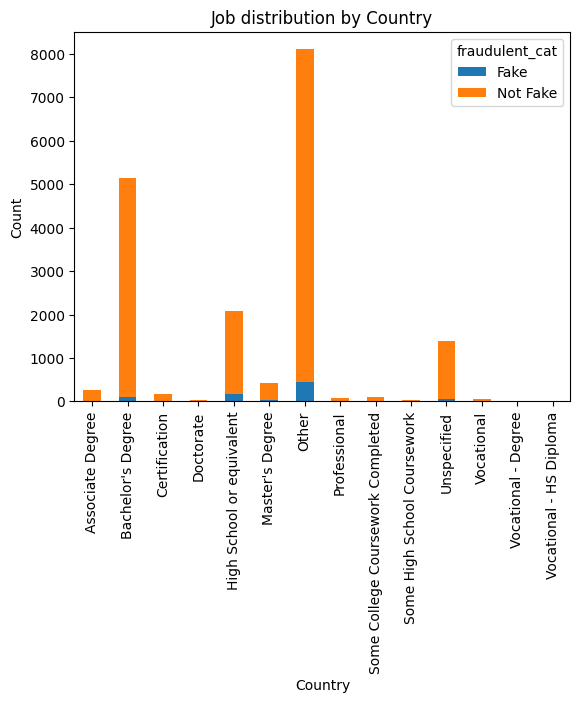

In [ ]:

df['country'] = df['location'].apply(lambda x: x.split(',')[0])

#plt.figure(figsize=(20,5))

grouped = df.groupby(['required_education'])['fraudulent_cat'].value_counts().unstack(fill_value=0)

#plot stacked bar chart
grouped.plot( kind='bar', stacked=True)
#add axis labels and title
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Job distribution by Country')

plt.show()

In [ ]:
#==================
#def location_split

plt.figure(figsize=(12,5))

grouped = df.groupby(['country'])['fraudulent_cat'].value_counts().unstack(fill_value=0)

plt.subplot(231)
#plot stacked bar chart
grouped.plot( kind='bar', stacked=True)
#add axis labels and title
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Job distribution by Country')

#plot stacked bar chart
plt.subplot(232)
grouped = df.groupby(['required_experience'])['fraudulent_cat'].value_counts().unstack(fill_value=0)
grouped.plot(kind='bar', color = ['brown', 'yellow'], stacked=True)
#add axis labels and title
plt.xlabel('required_experience')
plt.ylabel('Count')
plt.title('Job distribution by Required Experience')

#plot stacked bar chart
plt.subplot(233)
grouped = df.groupby(['required_education'])['fraudulent_cat'].value_counts().unstack(fill_value=0)
grouped.plot(kind='bar', color = ['orange', 'green'], stacked=True)
#add axis labels and title
plt.xlabel('employment_type')
plt.ylabel('Count')
plt.title('Job distribution by required_education')

#plot stacked bar chart
plt.subplot(234)
grouped = df.groupby(['employment_type'])['fraudulent_cat'].value_counts().unstack(fill_value=0)
grouped.plot(kind='bar', color = ['magenta', 'purple'], stacked=True)
#add axis labels and title
plt.xlabel('employment_type')
plt.ylabel('Count')
plt.title('Job distribution by employment_type')

#plot stacked bar chart
plt.subplot(235)
grouped = df.groupby(['salary_range'])['fraudulent_cat'].value_counts().unstack(fill_value=0)
grouped.plot(kind='bar', color = ['red', 'yellow'], stacked=True)
#add axis labels and title
plt.xlabel('salary_range')
plt.ylabel('Count')
plt.title('Job distribution by salary_range')

#plot stacked bar chart
#plt.subplot(236)
#grouped = df.groupby(['industry'])['fraudulent_cat'].value_counts().unstack(fill_value=0)
#grouped.plot(kind='bar', color = ['indigo', 'violet'], stacked=True)
#add axis labels and title
#plt.xlabel('industry')
#plt.ylabel('Count')
#plt.title('Job distribution by Industry')

plt.show()

In [ ]:

#===merge related columns into one and drop the associated columns==============

df['job_field'] = df['title'] +' '+ df['department'] +' '+ df['industry'] +' '+ df['function']
df.drop(['title','department','industry','function'] , axis = 1 , inplace = True )

# we merge requirements together and drop the associated olumns

df['Requirements'] = df['requirements'] +' ' + df['required_experience'] +' ' + df['required_education']
df.drop(['requirements','required_experience','required_education'], axis = 1 ,inplace = True )

#==drop fraudulent_cat (it was only use for EDA analysis)=======================
df.drop('fraudulent_cat', axis = 1, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   location          17880 non-null  object
 1   salary_range      17880 non-null  int64 
 2   company_profile   17880 non-null  object
 3   description       17880 non-null  object
 4   benefits          17880 non-null  object
 5   telecommuting     17880 non-null  int64 
 6   has_company_logo  17880 non-null  int64 
 7   has_questions     17880 non-null  int64 
 8   employment_type   17880 non-null  object
 9   fraudulent        17880 non-null  int64 
 10  job_field         17880 non-null  object
 11  Requirements      17880 non-null  object
dtypes: int64(5), object(7)
memory usage: 1.6+ MB


In [ ]:
##============== convert numerical and categorial columns to texts=================
def salary_conv(a):
    if a==0:
      return 'no salary'
    else:
      return "salary is {:}".format(a)

def tele_conv(a):
  if a==0:
    return 'No telecommuting'
  else:
    return 'there is telecommuting'

def logo_conv(a):
  if a==0:
    return 'No company logo'
  else:
    return 'there is company logo'

def ques_conv(a):
  if a==0:
    return 'No question was asked'
  else:
    return 'they asked questions'

###=====values to texts=================
df['salary_range'] = df['salary_range'].apply(salary_conv)
df['telecommuting'] = df['telecommuting'].apply(tele_conv)
df['has_company_logo'] = df['has_company_logo'].apply(logo_conv)
df['has_questions'] = df['has_questions'].apply(ques_conv)

In [ ]:
##=== cross check==================

dfff = df.copy()
dfff.info()
data_details(dfff)

print('The total number of data: ', len(dfff))

dfff.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   location          17880 non-null  object
 1   salary_range      17880 non-null  object
 2   company_profile   17880 non-null  object
 3   description       17880 non-null  object
 4   benefits          17880 non-null  object
 5   telecommuting     17880 non-null  object
 6   has_company_logo  17880 non-null  object
 7   has_questions     17880 non-null  object
 8   employment_type   17880 non-null  object
 9   fraudulent        17880 non-null  int64 
 10  job_field         17880 non-null  object
 11  Requirements      17880 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.6+ MB

 There is : 0  Nulls, Representing 0.00 % of The Data

 There is : 285  Duplicated, Representing 0.02 % of The Data

 Numerical Columns : {'fraudulent': 'Discrete'}

 Categorical Columns : {'loca

,location,salary_range,company_profile,description,benefits,telecommuting,has_company_logo,has_questions,employment_type,fraudulent,job_field,Requirements
0,"US, NY, New York",no salary,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",no available data,No telecommuting,there is company logo,No question was asked,Other,0,Marketing Intern Marketing Marketing,Experience with content management systems a m...
1,"NZ, , Auckland",no salary,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What you will get from usThrough being part of...,No telecommuting,there is company logo,No question was asked,Full-time,0,Customer Service - Cloud Video Production Succ...,What we expect from you:Your key responsibilit...
2,"US, IA, Wever",no salary,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",no available data,No telecommuting,there is company logo,No question was asked,Other,0,Commissioning Machinery Assistant (CMA) Commis...,Implement pre-commissioning and commissioning ...
3,"US, DC, Washington",no salary,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,Our culture is anything but corporate—we have ...,No telecommuting,there is company logo,No question was asked,Full-time,0,Account Executive - Washington DC Sales Comput...,"EDUCATION: Bachelor’s or Master’s in GIS, busi..."
4,"US, FL, Fort Worth",no salary,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,Full Benefits Offered,No telecommuting,there is company logo,they asked questions,Full-time,0,Bill Review Manager Bill Review Manager Hospit...,QUALIFICATIONS:RN license in the State of Texa...
5,"US, MD,",no salary,no available data,Job OverviewApex is an environmental consultin...,no available data,No telecommuting,No company logo,No question was asked,Other,0,Accounting Clerk Accounting,no available data Other Other
6,"DE, BE, Berlin",salary is 20000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Benefits: Being part of a fast-growing co...,No telecommuting,there is company logo,they asked questions,Full-time,0,Head of Content (m/f) ANDROIDPIT Online Media ...,Your Know-How: ...
7,"US, CA, San Francisco",no salary,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,Competitive Pay. You'll be able to eat steak e...,No telecommuting,there is company logo,they asked questions,Other,0,Lead Guest Service Specialist Lead Guest Se...,"Experience with CRM software, live chat, and p..."
8,"US, FL, Pensacola",no salary,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,no available data,No telecommuting,there is company logo,they asked questions,Full-time,0,HP BSM SME HP BSM SME Information Technology a...,MUST BE A US CITIZEN.An active TS/SCI clearanc...
9,"US, AZ, Phoenix",no salary,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,no available data,No telecommuting,there is company logo,No question was asked,Part-time,0,Customer Service Associate - Part Time Custom...,Minimum Requirements:Minimum of 6 months custo...


In [ ]:
##======== drop duplicated rows

dfff.drop_duplicates(inplace = True)

#data_details(df)

In [ ]:
#====meaningful column data we need for our training data===============
#dfff.rename_column("fraudulent", "labels")

dfff.rename(columns = {'fraudulent':'labels'}, inplace = True)
dfff.head(10)

###===split X-input and Y-input
labels = dfff['labels']
#labels.reshape(-1,1)
                                    ##rename column to 'labels'
train_data = dfff.drop(columns=['location','labels'])

print('label shape: ',labels.shape)

label shape:  (17595,)


In [ ]:
train_data.head(10)

,salary_range,company_profile,description,benefits,telecommuting,has_company_logo,has_questions,employment_type,job_field,Requirements
0,no salary,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",no available data,No telecommuting,there is company logo,No question was asked,Other,Marketing Intern Marketing Marketing,Experience with content management systems a m...
1,no salary,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What you will get from usThrough being part of...,No telecommuting,there is company logo,No question was asked,Full-time,Customer Service - Cloud Video Production Succ...,What we expect from you:Your key responsibilit...
2,no salary,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",no available data,No telecommuting,there is company logo,No question was asked,Other,Commissioning Machinery Assistant (CMA) Commis...,Implement pre-commissioning and commissioning ...
3,no salary,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,Our culture is anything but corporate—we have ...,No telecommuting,there is company logo,No question was asked,Full-time,Account Executive - Washington DC Sales Comput...,"EDUCATION: Bachelor’s or Master’s in GIS, busi..."
4,no salary,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,Full Benefits Offered,No telecommuting,there is company logo,they asked questions,Full-time,Bill Review Manager Bill Review Manager Hospit...,QUALIFICATIONS:RN license in the State of Texa...
5,no salary,no available data,Job OverviewApex is an environmental consultin...,no available data,No telecommuting,No company logo,No question was asked,Other,Accounting Clerk Accounting,no available data Other Other
6,salary is 20000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Benefits: Being part of a fast-growing co...,No telecommuting,there is company logo,they asked questions,Full-time,Head of Content (m/f) ANDROIDPIT Online Media ...,Your Know-How: ...
7,no salary,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,Competitive Pay. You'll be able to eat steak e...,No telecommuting,there is company logo,they asked questions,Other,Lead Guest Service Specialist Lead Guest Se...,"Experience with CRM software, live chat, and p..."
8,no salary,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,no available data,No telecommuting,there is company logo,they asked questions,Full-time,HP BSM SME HP BSM SME Information Technology a...,MUST BE A US CITIZEN.An active TS/SCI clearanc...
9,no salary,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,no available data,No telecommuting,there is company logo,No question was asked,Part-time,Customer Service Associate - Part Time Custom...,Minimum Requirements:Minimum of 6 months custo...


In [ ]:
##========== merge all text columns ============================================= .apply(lambda x: " ".join(x))

#train_data['text'] = train_data[train_data.columns[:]].apply(lambda x: '.'.join(x.dropna().astype(str)), axis=1)

#text_train_data = train_data['text']

#==== select suitable columns for our model (to minimize memory usage )

train_data['text'] = train_data['Requirements'] + ' ' + train_data['job_field'] + ' ' + train_data['benefits'] + ' ' + train_data['employment_type'] + ' ' + train_data['salary_range']

text_train_data = train_data['text']

train_data['text_len'] = train_data['text'].astype(str).apply(len)
train_data['text_word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))

print('maximum length is: ', max(train_data['text_len']))
#text_train_data = train_data['text']

maximum length is:  11013


In [ ]:
text_train_data.head(5)
#print(text_train_data[0])

0    Experience with content management systems a m...
1    What we expect from you:Your key responsibilit...
2    Implement pre-commissioning and commissioning ...
3    EDUCATION: Bachelor’s or Master’s in GIS, busi...
4    QUALIFICATIONS:RN license in the State of Texa...
Name: text, dtype: object

In [ ]:
##========== clean text column =================================================
#clean_text_data = preprocess_data(text_train_data)


In [ ]:
#clean_text_data[0]

In [ ]:
#========================split data=============================================

text_train_data.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)

train_texts, val_texts, train_labels, val_labels = train_test_split(text_train_data, labels,
                                                                    test_size=.2, random_state=42)

train_texts.reset_index(drop=True, inplace=True)
val_texts.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

In [ ]:
#============ Tokenize text data ===================

import torch.nn.utils.rnn as rnn_utils
from transformers import DistilBertTokenizerFast

## Import BERT tokenizer
MAX_LEN = 512

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_txt = [txt for txt in train_texts.values]
val_txt = [txt for txt in val_texts.values]



train_encodings = tokenizer(train_txt, max_length=MAX_LEN, truncation=True, padding=True)
val_encodings = tokenizer(val_txt, max_length=MAX_LEN, truncation=True, padding=True)



In [ ]:
#print(len(tr_attention_masks))

14076


In [ ]:

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
#==============Prepare the segmented input data=================================

train_datasets = CustomDataset(train_encodings, train_labels)
val_datasets = CustomDataset(val_encodings, val_labels)

In [ ]:
##==== custom Trainer loss to handle imbalanced datasets
from transformers import Trainer
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch import nn
from sadice import SelfAdjDiceLoss

#computing the class weights

#train_labels = train_labels.values
#computing the class weights
class_wts = compute_class_weight(class_weight = "balanced", classes = np.unique(train_labels), y = train_labels)
print(f'job_detection classification: ', np.unique(train_labels))
print(f"Class weights => {class_wts}")

#================================ Custom Trainer =================
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_wts))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

class CustomTrainerSadice(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss
        criterion = SelfAdjDiceLoss()
        loss = criterion(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        #loss = criterion(logits, outputs)
        return (loss, outputs) if return_outputs else loss

job_detection classification:  [0 1]
Class weights => [ 0.52448021 10.71232877]


**Training the model using Transformer**

In [ ]:
from transformers import logging

logging.set_verbosity_warning()

In [ ]:
#== set up metrics===============
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

num_labels = 2
id2label = {0: 'not_Fake', 1: 'Fake'}
label2id = {'not_Fake': 0, 'Fake': 1}
model_name = "distilbert-base-uncased"
model = (DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels,
                                                            id2label=id2label, label2id=label2id).to(device))

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


batch_size = 32
logging_steps = len(train_texts) // batch_size


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
##========== using baseline trainer ===========================
#===========args/parameters specification======================================

training_args = TrainingArguments(output_dir="./base_results",
                                  num_train_epochs=8,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  logging_dir='./base_logs',
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False)

trainer_1 = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    args=training_args,
    train_dataset=train_datasets,
    eval_dataset=val_datasets
)


trainer_1.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#==== using custom loss with class weights======================================

training_args = TrainingArguments(output_dir="./custom1_results",
                                  num_train_epochs=8,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  logging_dir='./custom1_logs',
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False)
trainer_2 = CustomTrainer(
    model=model,
    compute_metrics=compute_metrics,
    args=training_args,
    train_dataset=train_datasets,
    eval_dataset=val_datasets
)
trainer_2.train()

In [ ]:
#==== using Sadice loss=========================

training_args = TrainingArguments(output_dir="./custom2_results",
                                  num_train_epochs=8,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  logging_dir='./custom2_logs',
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  disable_tqdm=False)

trainer_3 = CustomTrainerSadice(
    model=model,
    compute_metrics=compute_metrics,
    args=training_args,
    train_dataset=train_datasets,
    eval_dataset=val_datasets
)
trainer_3.train()

**Evaluate model**

In [ ]:
results1 = trainer_1.evaluate()
print('baseline model evaluation result: ', results1)

results2 = trainer_2.evaluate()
print('custom weight_class model result: ', results2)

results3 = trainer_3.evaluate()
print('custom sadice_loss model result: ', results3)

In [ ]:
preds_output = trainer_1.predict(val_encodings)
preds_output.metrics

In [ ]:
import numpy as np
y_valid = np.array(val_labels)
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12,8))

conf_matrix = confusion_matrix(y_valid, y_preds)

sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

labels = ['Negative', 'Positive']
plt.xticks(np.arange(len(labels))+0.5, labels)
plt.yticks(np.arange(len(labels))+0.5, labels)
plt.show()

#cm = confusion_matrix(y_valid, y_preds)
#f = sns.heatmap(cm, annot=True, fmt='d')

Save the Model

In [ ]:
model.save_pretrained('./fake-job-model')
#tokenizer.save_pretrained('./model')

## Others

In [ ]:
##############
from multiprocessing import Pool, cpu_count
from functools import partial
from nltk.stem import WordNetLemmatizer


def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove special characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = re.sub(r'(@|#)\w+' , '' , text)
    text = re.sub("[,.]", "", text)
    text = re.sub(r'https?://\S+' , '' , text)
    text = re.sub(r'(\?|!)+' , '' , text)
    text = re.sub(r"\(|\)", "", text)
    text = re.sub(r'(^\s+)' , '' , text)
    text = re.sub(r'(\s+$)' , '' , text)
    #text = re.sub(r'\d+' , '' , text)

    # Expand contractions
    tokens  = text.split()
    tokens = [contractions.fix(token) for token in tokens]           # expand words
    text = " ".join(tokens)

    # Convert numeric values to text expressions
    p = inflect.engine()
    tokens = text.split()
    tokens = [p.number_to_words(token) if token.isdigit() else token for token in tokens]
    text = " ".join(tokens)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    text = " ".join(tokens)

    # Perform stemming
    stemmer = SnowballStemmer("english")
    tokens = text.split()
    tokens = [stemmer.stem(token) for token in tokens]               # stemming
    text = " ".join(tokens)

    return text


#== this is included when using parallel computing to speed up the process

def preprocess_text_parallel(text):
        return preprocess_text(text)


def preprocess_data(data, num_processes=None):
    if num_processes is None:
        num_processes = cpu_count()

    if isinstance(data, (str, np.ndarray)):
        return preprocess_text(data)

    elif isinstance(data, (list, pd.Series)):
        with Pool(processes=num_processes) as pool:
            preprocessed_data = pool.map(preprocess_text_parallel, data)
        return np.array(preprocessed_data)

    elif isinstance(data, pd.DataFrame):
        # Preprocess text columns in a DataFrame using parallel processing
        with Pool(processes=num_processes) as pool:
            func = partial(preprocess_text_parallel)
            preprocessed_data = pool.map(func, data.values.flatten())
            preprocessed_data = np.array(preprocessed_data).reshape(data.shape)
            preprocessed_data = pd.DataFrame(preprocessed_data, columns=data.columns)
        return preprocessed_data
    else:
        raise ValueError("Input data must be a string, column series, array, or a DataFrame.")

###===========maximum length computation========================================
def maximum_length(df):
  max_len = 0
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  # For every sentence...
  for col in df:
      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(col, add_special_tokens=True)
      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))
  return max_len

#print('Max sentence length: ', max_len)

In [ ]:

###========segment tokenize data to 512 inputs =================================

#segmented_input_ids, segmented_attention_masks, train_labels = tokenize_data(train_texts, train_labels)
#val_input_ids, val_attention_masks, val_labels = tokenize_data(val_texts, val_labels)

#segmented_input_ids, segmented_attention_masks, train_labels = optimized_tokenize_data(train_texts, train_labels)
#val_input_ids, val_attention_masks, val_labels = optimized_tokenize_data(val_texts, val_labels)


In [ ]:
#========   tokenize the data===================================================
from transformers import BertTokenizer
import torch.nn.utils.rnn as rnn_utils

def tokenize_data(df, labels):
    # Tokenize the text columns using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encode_id = []
    encode_mask = []
    max_length = 300

    ##=====loop through columns and tokenize====================================
    for col in df:
        encoded_dict = tokenizer.batch_encode_plus(
            col,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        encode_id.append(encoded_dict['input_ids'])
        encode_mask.append(encoded_dict['attention_mask'])


    input_ids = torch.cat(encode_id, dim=0)
    attention_masks = torch.cat(encode_mask, dim=0)
    labels = torch.tensor(labels)

    # save the tokenizer
    tokenizer.save_pretrained('./trained_tokenizer')
    return input_ids, attention_masks, labels

def optimized_tokenize_data(df, labels):
    # Tokenize the text columns using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    encode_id = []
    encode_mask = []
    max_length = 256  # You can adjust the max_length based on your memory constraints

    # Create batches of text data for tokenization
    batch_size = 32  # Adjust the batch size based on your memory constraints
    num_samples = len(df)
    num_batches = (num_samples + batch_size - 1) // batch_size

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min((batch_idx + 1) * batch_size, num_samples)

        # Tokenize the text in the batch
        encoded_dict = tokenizer.batch_encode_plus(
            df[batch_start:batch_end].tolist(),
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        encode_id.append(encoded_dict['input_ids'])
        encode_mask.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(encode_id, dim=0)
    attention_masks = torch.cat(encode_mask, dim=0)
    labels = torch.tensor(labels)

    # Save the tokenizer
    tokenizer.save_pretrained('./trained_tokenizer')
    return input_ids, attention_masks, labels

In [ ]:
def tokens_seg(encoded_input_ids, encoded_attention_masks, labels):
    # Define the maximum segment length
    max_segment_length = 512

    # Create empty lists to store segmented data
    segmented_input_ids = []
    segmented_attention_masks = []
    segmented_labels = []

    # Iterate over each example in the dataset
    for example_input_ids, example_attention_mask, example_label in zip(encoded_input_ids, encoded_attention_masks, labels):
        # Calculate the number of segments needed
        num_segments = len(example_input_ids) // max_segment_length
        if len(example_input_ids) % max_segment_length != 0:
            num_segments += 1

        # Segment the input IDs, attention masks, and labels
        for i in range(num_segments):
            start_idx = i * max_segment_length
            end_idx = (i + 1) * max_segment_length

            # Truncate or pad the input IDs, attention masks, and labels to the maximum segment length
            truncated_input_ids = torch.zeros(max_segment_length, dtype=torch.long)
            truncated_attention_mask = torch.zeros(max_segment_length, dtype=torch.long)
            truncated_label = torch.zeros(1, dtype=torch.long)
            segment_length = min(max_segment_length, len(example_input_ids) - start_idx)

            truncated_input_ids[:segment_length] = example_input_ids[start_idx:start_idx + segment_length]
            truncated_attention_mask[:segment_length] = example_attention_mask[start_idx:start_idx + segment_length]
            truncated_label[0] = example_label.item()  # Assuming example_label is a tensor

            # Add the segmented input IDs, attention masks, and labels to the lists
            segmented_input_ids.append(truncated_input_ids)
            segmented_attention_masks.append(truncated_attention_mask)
            segmented_labels.append(truncated_label)

    # Convert the segmented input IDs, attention masks, and labels to tensors
    segmented_input_ids = torch.stack(segmented_input_ids)
    segmented_attention_masks = torch.stack(segmented_attention_masks)
    segmented_labels = torch.stack(segmented_labels)
    return segmented_input_ids, segmented_attention_masks, segmented_labels